# Final Submission: Yelp Reviews

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyspark.pandas as ps

Matplotlib created a temporary cache directory at /tmp/matplotlib-0gigg14f because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
import sys
import site
sys.path.append(site.getusersitepackages())
!{sys.executable} -m pip install plotly --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Yelp Data Analysis") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "8") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.memoryOverhead", "4g") \
    .config("spark.driver.memoryOverhead", "4g") \
    .config("spark.sql.shuffle.partitions", "800") \
    .getOrCreate()

In [4]:
review_df = spark.read.json('yelp_academic_dataset_review.json')

## Data Cleaning and Preprocessing

### Select features

In [5]:
review_df = review_df.select('text','stars')
print('Total Count: ' + str(review_df.count()))
review_df.show(5)

Total Count: 187030
+--------------------+-----+
|                text|stars|
+--------------------+-----+
|If you decide to ...|  3.0|
|I've taken a lot ...|  5.0|
|Family diner. Had...|  3.0|
|Wow!  Yummy, diff...|  5.0|
|Cute interior and...|  4.0|
+--------------------+-----+
only showing top 5 rows



### Remove Missing Values

In [6]:
#dropping rows with any null values
review_df = review_df.dropna()
review_df.count()

187029

### Add feature: 'review_length'

In [7]:
from pyspark.sql.functions import col, count, when, length

review_df = review_df.withColumn('review_length', length('text'))
review_df.show(5)

+--------------------+-----+-------------+
|                text|stars|review_length|
+--------------------+-----+-------------+
|If you decide to ...|  3.0|          513|
|I've taken a lot ...|  5.0|          829|
|Family diner. Had...|  3.0|          339|
|Wow!  Yummy, diff...|  5.0|          243|
|Cute interior and...|  4.0|          534|
+--------------------+-----+-------------+
only showing top 5 rows



### Tokenization and Stop Words Removal

In [8]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_df = tokenizer.transform(review_df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(tokenized_df)

filtered_df.show(5)

+--------------------+-----+-------------+--------------------+--------------------+
|                text|stars|review_length|               words|      filtered_words|
+--------------------+-----+-------------+--------------------+--------------------+
|If you decide to ...|  3.0|          513|[if, you, decide,...|[decide, eat, her...|
|I've taken a lot ...|  5.0|          829|[i've, taken, a, ...|[taken, lot, spin...|
|Family diner. Had...|  3.0|          339|[family, diner., ...|[family, diner., ...|
|Wow!  Yummy, diff...|  5.0|          243|[wow!, , yummy,, ...|[wow!, , yummy,, ...|
|Cute interior and...|  4.0|          534|[cute, interior, ...|[cute, interior, ...|
+--------------------+-----+-------------+--------------------+--------------------+
only showing top 5 rows



### Sentiment Polarity Scores

In [9]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

#initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

#define a function to calculate sentiment scores
def sentiment_scores(text):
    scores = sia.polarity_scores(text)
    return float(scores['compound'])

In [10]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType, FloatType

sentiment_udf = udf(sentiment_scores, FloatType())

polarity_df = filtered_df.withColumn('sentiment_polarity', sentiment_udf(col('text')))
polarity_df.show(5)

+--------------------+-----+-------------+--------------------+--------------------+------------------+
|                text|stars|review_length|               words|      filtered_words|sentiment_polarity|
+--------------------+-----+-------------+--------------------+--------------------+------------------+
|If you decide to ...|  3.0|          513|[if, you, decide,...|[decide, eat, her...|            0.8597|
|I've taken a lot ...|  5.0|          829|[i've, taken, a, ...|[taken, lot, spin...|            0.9858|
|Family diner. Had...|  3.0|          339|[family, diner., ...|[family, diner., ...|            0.9201|
|Wow!  Yummy, diff...|  5.0|          243|[wow!, , yummy,, ...|[wow!, , yummy,, ...|            0.9588|
|Cute interior and...|  4.0|          534|[cute, interior, ...|[cute, interior, ...|            0.9804|
+--------------------+-----+-------------+--------------------+--------------------+------------------+
only showing top 5 rows



### TF-IDF

In [11]:
from pyspark.ml.feature import HashingTF, IDF

# Apply TF-IDF
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="hashing_tf")
tf_df = hashing_tf.transform(polarity_df)
idf = IDF(inputCol="hashing_tf", outputCol="TF_IDF")
idf_model = idf.fit(tf_df)
tfidf_df = idf_model.transform(tf_df)

tfidf_df.show(5)

+--------------------+-----+-------------+--------------------+--------------------+------------------+--------------------+--------------------+
|                text|stars|review_length|               words|      filtered_words|sentiment_polarity|          hashing_tf|              TF_IDF|
+--------------------+-----+-------------+--------------------+--------------------+------------------+--------------------+--------------------+
|If you decide to ...|  3.0|          513|[if, you, decide,...|[decide, eat, her...|            0.8597|(262144,[12524,24...|(262144,[12524,24...|
|I've taken a lot ...|  5.0|          829|[i've, taken, a, ...|[taken, lot, spin...|            0.9858|(262144,[18176,29...|(262144,[18176,29...|
|Family diner. Had...|  3.0|          339|[family, diner., ...|[family, diner., ...|            0.9201|(262144,[578,1261...|(262144,[578,1261...|
|Wow!  Yummy, diff...|  5.0|          243|[wow!, , yummy,, ...|[wow!, , yummy,, ...|            0.9588|(262144,[30899,45...|

## Prepare data for Modeling

In [12]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

In [13]:
#Assembling features
assembler = VectorAssembler(inputCols=['review_length','sentiment_polarity', 'TF_IDF'], outputCol='combined_features')
final_df = assembler.transform(tfidf_df)

## Logistic Regression Model

In [20]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [21]:
#select features
select_df = final_df.select('combined_features', 'stars')
select_df.show(5)

+--------------------+-----+
|   combined_features|stars|
+--------------------+-----+
|(262146,[0,1,1252...|  3.0|
|(262146,[0,1,1817...|  5.0|
|(262146,[0,1,580,...|  3.0|
|(262146,[0,1,3090...|  5.0|
|(262146,[0,1,1691...|  4.0|
+--------------------+-----+
only showing top 5 rows



In [22]:
label_indexer = StringIndexer(inputCol="stars", outputCol="label")
labeled_df = label_indexer.fit(select_df).transform(select_df)

In [23]:
data_df = labeled_df.select('combined_features', 'stars')

In [18]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

lr = LogisticRegression(featuresCol="combined_features", labelCol="stars")

# Create the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 1.0])
             .addGrid(lr.elasticNetParam, [0.3, 0.7, 1.0])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="stars", predictionCol="prediction", metricName="accuracy")

# Define the CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 3+ in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(data_df)

# Make predictions on the test data
predictions = cvModel.transform(data_df)

# Evaluate the model
accuracy = evaluator.evaluate(predictions)
print(f"Cross-validated Accuracy: {accuracy}")

# Extract the best model
bestModel = cvModel.bestModel

# Print best hyperparameters
print("Best regParam: ", bestModel._java_obj.getRegParam())
print("Best elasticNetParam: ", bestModel._java_obj.getElasticNetParam())

Cross-validated Accuracy: 0.6194280031438975
Best regParam:  0.01
Best elasticNetParam:  0.3


In [24]:
train_df, test_df = labeled_df.randomSplit([0.8, 0.2], seed=42)

In [25]:
complexities = [0.001, 0.01, 0.1, 1.0]
train_accuracies = []
test_accuracies = []
for reg in complexities:
    lr = LogisticRegression(featuresCol='combined_features', labelCol='label', maxIter=100, regParam=reg, elasticNetParam=0.3,
                            family='multinomial', aggregationDepth = 2)
    lr_model = lr.fit(train_df)
    lr_train_pred = lr_model.transform(train_df)
    lr_test_pred = lr_model.transform(test_df)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    lr_train_accuracy = evaluator.evaluate(lr_train_pred)
    train_accuracies.append(lr_train_accuracy)
    
    lr_test_accuracy = evaluator.evaluate(lr_test_pred)
    test_accuracies.append(lr_test_accuracy)


In [26]:
train_accuracies

[0.9336696225420529, 0.6234428274983153, 0.509978581580159, 0.4444355479045312]

In [27]:
test_accuracies

[0.6041498466010011,
 0.6121158297001992,
 0.5095807094030895,
 0.4452607782980785]

### Overfitting/Underfitting Graph

[0.5555644520954688, 0.49002141841984104, 0.37655717250168474, 0.06633037745794712]
[0.5547392217019216, 0.4904192905969105, 0.3878841702998008, 0.39585015339899887]


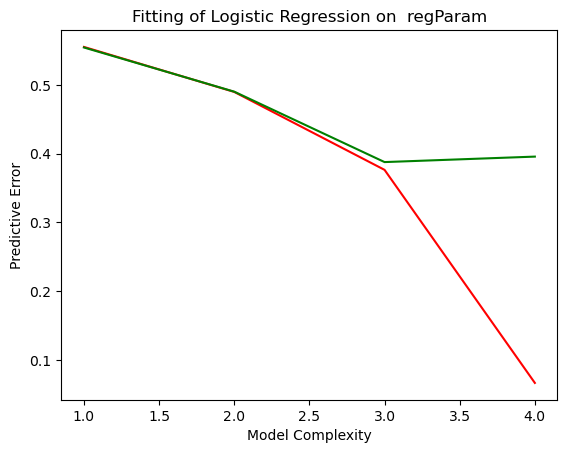

In [34]:
train_plot = [1-train_accuracies[i] for i in range(len(train_accuracies))]
test_plot = [1-test_accuracies[i] for i in range(len(test_accuracies))]
train_plot = train_plot[::-1]
test_plot = test_plot[::-1]
print(train_plot)
print(test_plot)
x = [1,2,3,4]
import matplotlib.pyplot as plt
plt.plot(x, train_plot, color='red', label='train_data')
plt.plot(x, test_plot, color='green', label='test_data')

plt.title('Fitting of Logistic Regression on  regParam')
plt.xlabel('Model Complexity')
plt.ylabel('Predictive Error')

plt.show()

## SVM

In [38]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [39]:
#select features
select_df = final_df.select('combined_features', 'stars')
select_df.show(5)

+--------------------+-----+
|   combined_features|stars|
+--------------------+-----+
|(262146,[0,1,1252...|  3.0|
|(262146,[0,1,1817...|  5.0|
|(262146,[0,1,580,...|  3.0|
|(262146,[0,1,3090...|  5.0|
|(262146,[0,1,1691...|  4.0|
+--------------------+-----+
only showing top 5 rows



In [40]:
label_indexer = StringIndexer(inputCol="stars", outputCol="label")
labeled_df = label_indexer.fit(select_df).transform(select_df)
labeled_df.show(5)

+--------------------+-----+-----+
|   combined_features|stars|label|
+--------------------+-----+-----+
|(262146,[0,1,1252...|  3.0|  2.0|
|(262146,[0,1,1817...|  5.0|  0.0|
|(262146,[0,1,580,...|  3.0|  2.0|
|(262146,[0,1,3090...|  5.0|  0.0|
|(262146,[0,1,1691...|  4.0|  1.0|
+--------------------+-----+-----+
only showing top 5 rows



In [41]:
train_df, test_df = labeled_df.randomSplit([0.8, 0.2], seed=42)

In [43]:
complexities = [0.001, 0.01, 0.1, 1.0]
train_accuracies = []
test_accuracies = []
for reg in complexities:
    svm = LinearSVC(featuresCol='combined_features', labelCol='label', maxIter=100, regParam=reg)

    ovr = OneVsRest(classifier=svm, labelCol='label', featuresCol='combined_features')
    ovr_model = ovr.fit(train_df)x
    
    svm_train_pred = ovr_model.transform(train_df)
    svm_test_pred = ovr_model.transform(test_df)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    
    svm_train_accuracy = evaluator.evaluate(svm_train_pred)
    train_accuracies.append(svm_train_accuracy)
    
    svm_test_accuracy = evaluator.evaluate(svm_test_pred)
    test_accuracies.append(svm_test_accuracy)

0.001
0.01
0.1
1.0


In [44]:
train_accuracies

[0.9637755136083699, 0.9452929519386672, 0.907053399256694, 0.8089156674740277]

In [45]:
test_accuracies

[0.5451046880887023,
 0.5722590020991442,
 0.5838042951719683,
 0.5544431885462081]

### Overfitting/Underfitting Graph

[0.19108433252597234, 0.09294660074330596, 0.05470704806133275, 0.03622448639163012]
[0.4455568114537919, 0.4161957048280317, 0.42774099790085585, 0.45489531191129773]


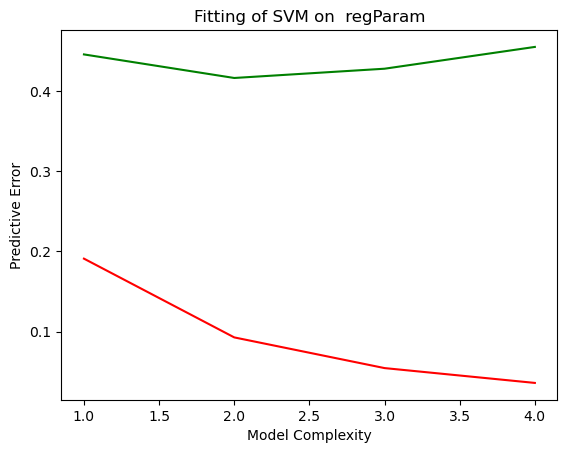

In [47]:
train_plot = [1-train_accuracies[i] for i in range(len(train_accuracies))]
test_plot = [1-test_accuracies[i] for i in range(len(test_accuracies))]
train_plot = train_plot[::-1]
test_plot = test_plot[::-1]
print(train_plot)
print(test_plot)
x = [1,2,3,4]
import matplotlib.pyplot as plt
plt.plot(x, train_plot, color='red', label='train_data')
plt.plot(x, test_plot, color='green', label='test_data')

plt.title('Fitting of SVM on  regParam')
plt.xlabel('Model Complexity')
plt.ylabel('Predictive Error')

plt.show()